# Sample RPGF3 List ✨

### Note: this list is just for fun and not a real funding recommendation!

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd
from scripts.oso_db import execute_query, execute_saved_query

In [2]:
app_data_path = "data/RPGF3/2023-10-31_RPGF3_cleaned_applicant_data.json"
with open(app_data_path) as j:
    app_data = json.load(j)

In [3]:
SLUG_KEY = 'Slug: Primary'

In [4]:
oss_apps = [p for p in app_data if p[SLUG_KEY]]
df = pd.DataFrame(oss_apps)
df.drop_duplicates(subset=['Link'], keep='last', inplace=True)
print(f"Analysis includes {len(df)} OSS projects.")

Analysis includes 315 OSS projects.


In [5]:
slugs = list(set([p[SLUG_KEY].lower() for p in oss_apps]))
print(f"... and {len(slugs)} unique slugs.")

... and 289 unique slugs.


In [6]:
# Check if any projects have duplicate slugs (and need closer review)

to_review = df[SLUG_KEY].value_counts()
to_review = to_review[to_review>1]
(
    df[df[SLUG_KEY]
       .isin(to_review.index)]
    .sort_values(by=SLUG_KEY)
    [['Project Name', SLUG_KEY, 'Payout Address']]
)

,Project Name,Slug: Primary,Payout Address
190,Awesome Optimism,awesome-optimism-lucas-op,0x82aCDE34C057B009041B030f34F03a11f50735bf
75,Abhinav,awesome-optimism-lucas-op,0x23583685Ff8d24cD53B9809D2686fB03746E069e
133,Bedrock Contracts Architecture Diagram,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
107,ERC1155 Bridge,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
150,Kristofer Lund,givepraise,0xa32aECda752cF4EF89956e83d60C04835d4FA867
137,Praise,givepraise,0x0B7246eF74Ca7b37Fdc3D15be4f0b49876622F95
36,ITU Blockchain,itu-blockchain,0xBEC643BD5b7F5e9190617CA4187ef0455950C51C
128,Clave (formerly Opclave),itu-blockchain,0x3E2e8E11c307830b358959F27128de4E93AC9FA4
218,Donate3,lxdao-official,0xb15115A15d5992A756D003AE74C0b832918fAb75
177,EIP Fun,lxdao-official,0xEe972E35311F65e6fD8F6ea7228Bf388B53e1D4a


In [7]:
slugs_to_ids = df.set_index(SLUG_KEY)['Project ID'].to_dict()

## Query: get the first 69 stars from all OSS projects in RPGF3

In [8]:
slugs_list = "','".join(slugs)
stopper = 69
query = f"""
    WITH RankedEvents AS (
        SELECT
            e.time,
            p.slug,
            ROW_NUMBER() OVER (PARTITION BY p.slug ORDER BY e.time) AS row_num
        FROM
            event e
        LEFT JOIN
            project_artifacts_artifact paa ON e."toId" = paa."artifactId"
        LEFT JOIN
            project p ON paa."projectId" = p."id"
        WHERE
            p.slug IN ('{slugs_list}')
            AND e."typeId" = 21
    )
    SELECT
        time,
        slug
    FROM
        RankedEvents
    WHERE
        row_num <= {stopper}
    ORDER BY
        slug,
        time;
"""
results = execute_query(query, col_names=False)

In [9]:
project_dates = defaultdict(list)

for date_str, project in results:
    project_dates[project].append(date_str)

project_ages = {}

for project, dates in project_dates.items():
    if len(dates) >= stopper:
        project_ages[project] = (datetime.now().timestamp() - dates[stopper-1].timestamp()) / (60*60*24)
    else:
        project_ages[project] = 0

## View results and export a list

In [10]:
def listify(lst, amount):
    total = sum(project_ages.values())
    factor = amount / total
    new_list = {k:round(v*factor,2) for k,v in project_ages.items() if v>0}
    new_list = dict(sorted(new_list.items(), key = lambda x: x[1], reverse=True))
    return new_list

named_list = listify(project_ages, 30000000)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

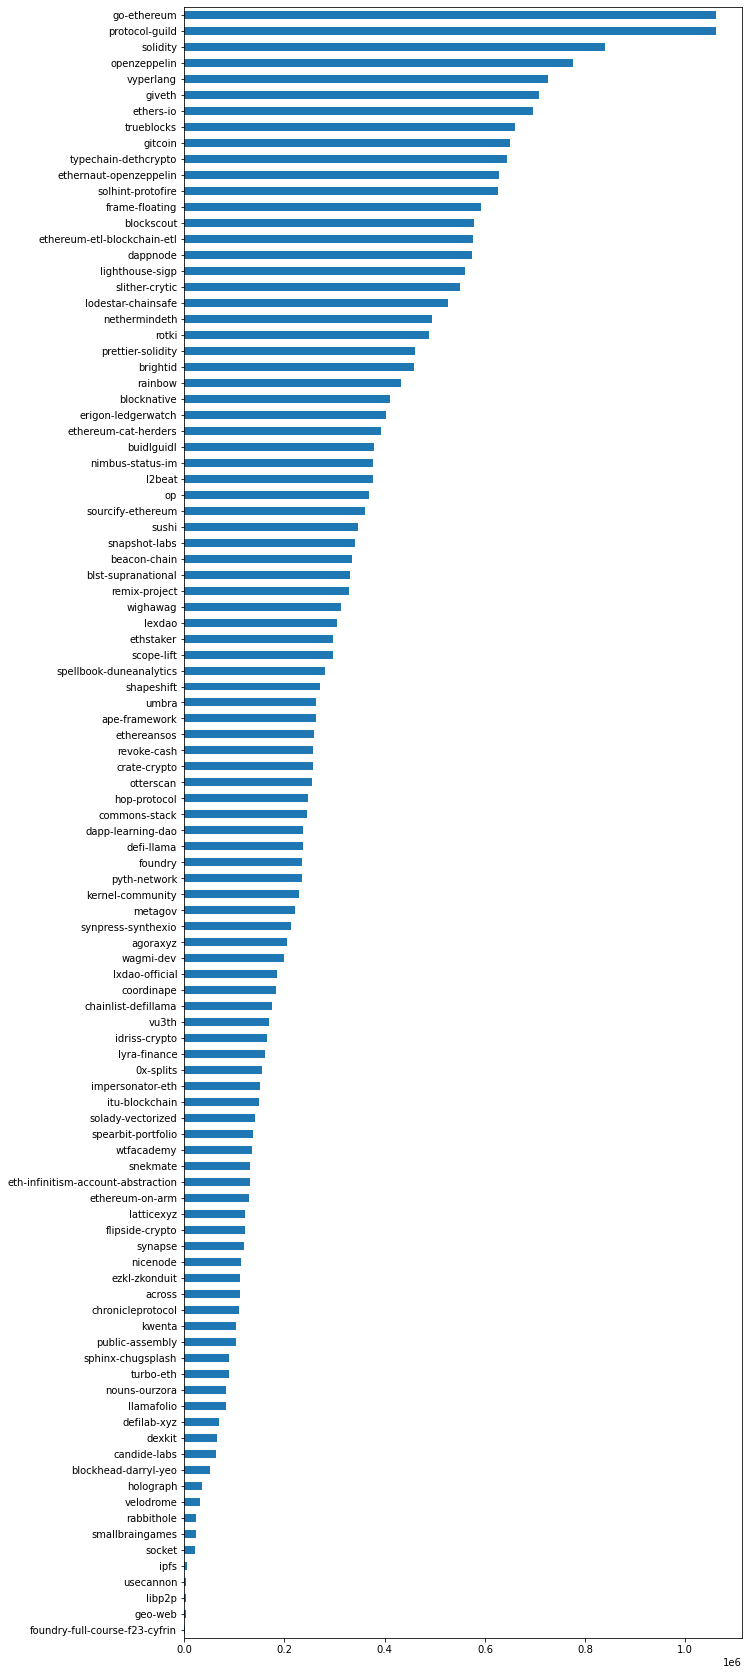

In [11]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,30))

In [12]:
# https://optimism.easscan.org/schema/view/0x3e3e2172aebb902cf7aa6e1820809c5b469af139e7a4265442b1c22b97c6b2a5

def create_eas_json(allocation_dict, list_name, list_link, list_descr, list_categories):
    return {
        'listDescription': list_name,
        'impactEvaluationLink': list_link,
        'impactEvaluationDescription': list_descr,
        'impactCategory': list_categories,
        'listContent': [
            {'RPGF3_Application_UID': k, 'OPAmount': v} for k,v in allocation_dict.items()
        ]
    }

eas_metadata = create_eas_json(
    allocation_dict=rpgf_list,
    list_name="Star69",
    list_link="https://github.com/opensource-observer/insights/blob/main/notebooks/2023-10-29_ListStar69.ipynb",
    list_descr="This list only considers projects with open source GitHub repos that have received more than 69 stars. The list identifies when the project received its 69th star and allocates OP Tokens based on how many days it's been since then. In other words, it favors popular, older OSS projects over newer and/or less popular OSS projects.",
    list_categories=['DEVELOPER_ECOSYSTEM', 'END_USER_EXPERIENCE_AND_ADOPTION', 'OP_STACK']
)

In [13]:
with open("data/RPGF3/Star69_Metadata.json", "w") as f:
    json.dump(eas_metadata, f, indent=4)